# Problem Overview:

Clustering is one of the important unsupervised learning techniques that can group the data points based upon their inherent properties. In unsupervised learning, there is no labelled data to train the machine learning model. That means there is no guidance or supervision to teach the model about the relationship between input features and output variable. The model itself tries to understand the relationships among the features and extracts the pattern hidden in it. In clustering, the learning algorithm understands this pattern and groups the data points into different segments based on the inherent properties.
Segmentation is also crucial to solve several business problems. Segmentation allows us to understand the inherent properties of grouped data points. In this case study also, we will attempt to use clustering to segment data points related to automobiles.

Dataset: https://www.kaggle.com/uciml/autompg-dataset

Each row of the dataset represents a car from the inventory, each column contains the car’s attributes. The attributes are given below:

- mpg: mileage per gallon 
- cylinders: number of cylinders
- displacement: Engine displacement
- horsepower: Engine Horsepower
- weight: weight of the car
- acceleration: acceleration of cars - zero to sixty miles/hour time
- model year: year of model
- origin: origin of car

In [33]:
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.externals import joblib
import math

print("pandas version: {} numpy version: {}".format(pd.__version__, np.__version__))

sklearn_version = sklearn.__version__
print('The scikit-learn version is {}.'.format(sklearn_version))
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

import azureml
import azureml.core
from azureml.core import Workspace, Experiment, Run
from azureml.core import Datastore, Dataset
from azureml.core.model import Model
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.image import Image

from interpret.ext.blackbox import TabularExplainer
from azureml.interpret.scoring.scoring_explainer import TreeScoringExplainer, save

print('The azureml.core version is {}.'.format(azureml.core.VERSION))

pandas version: 0.23.4 numpy version: 1.16.6
The scikit-learn version is 0.20.3.
The azureml.core version is 1.12.0.


## Setup with Azure Subscription

In [5]:
#Provide the Subscription ID of your existing Azure subscription
subscription_id = "5781be4e-7862-42f9-8ae8-e879c711039b" # <- needs to be the subscription within the Azure resource group for this lesson

#Provide values for the existing Resource Group 
resource_group = "aml-quickstarts-105801" # <- enter the name of your Azure Resource Group

#Provide the Workspace Name and Azure Region of the Azure Machine Learning Workspace
workspace_name = "quick-starts-ws-105801" # <- enter the name of the Azure Machine Learning workspace
workspace_region = "eastus" # <- region of your Azure Machine Learning workspace 

experiment_name = "auto_clustering"

# Connect Azure workspace 

In [6]:
ws = Workspace.create(
    name = workspace_name,
    subscription_id = subscription_id,
    resource_group = resource_group, 
    location = workspace_region,
    exist_ok = True)

ws.write_config()
print('Workspace configuration succeeded')

Workspace configuration succeeded


# Load data from datastore
### Datastore was created by uploading local file

In [8]:
datastore_name = 'workspaceblobstore'

# get existing workspace
workspace = Workspace.from_config()
    
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, datastore_name)

# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(datastore, 'UI/09-19-2020_014237_UTC/auto-miles-per-gallon.csv')]

df = Dataset.Tabular.from_delimited_files(path=datastore_paths)

# Convert to Pandas dataframe

In [9]:
df = df.to_pandas_dataframe()
df.head()

,MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODELYEAR,NAME
0,18.0,8,307.0,130,3504,12.0,70,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,ford torino


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
MPG             398 non-null float64
CYLINDERS       398 non-null int64
DISPLACEMENT    398 non-null float64
HORSEPOWER      398 non-null object
WEIGHT          398 non-null int64
ACCELERATION    398 non-null float64
MODELYEAR       398 non-null int64
NAME            398 non-null object
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


# Clean the HORSEPOWER column as there was some missing data with "?" sign

In [12]:
df = df[df.HORSEPOWER != "?"]
df["HORSEPOWER"] = pd.to_numeric(df["HORSEPOWER"])
df = df.drop("NAME", axis=1)

# Start the experiment

In [30]:
experiment = Experiment(workspace=ws, name="clustering-experiment")

# Hyperparameter tuning for KMeans clustering with Azure runs

In [31]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="clustering-experiment")

ss = StandardScaler()
df = ss.fit_transform(df)

k_values = range(2, 12)
WSSSD = []
for k in k_values:
    print(k)
    run = experiment.start_logging()
    run.log("k_value", k)
    model = Pipeline(steps=[('preprocessor', StandardScaler()),
                      ('clusterer', KMeans(n_clusters=k, n_jobs=-1))])
    model.fit(df)
    WSSSD.append(model.named_steps['clusterer'].inertia_)
    run.log("WSSSD", model.named_steps['clusterer'].inertia_)
    model_name = "model_k_" + str(k) + ".pkl"
    filename = "outputs/" + model_name
    
    joblib.dump(value=model, filename=filename)
    run.upload_file(name=model_name, path_or_stream=filename)
    run.complete()

2
3
4
5
6
7
8
9
10
11


# Elbow Plot

[<matplotlib.lines.Line2D at 0x7f82bfc40fd0>]

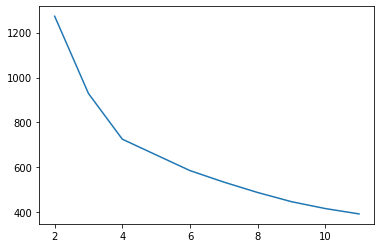

In [32]:
plt.plot(k_values, WSSSD)

### Best value found from Elbow Plot is 4. Lets consider the model having K = 4.

# Locate the best model that was trained (k = 4)

In [35]:
import os

model_folder = './outputs'
model_file_name = 'model_k_4.pkl'
model_path = os.path.join(model_folder, model_file_name)

# Register Model

Azure Machine Learning provides a Model Registry that acts like a version controlled repository for each of the trained models. 

In [36]:
model = Model.register(model_path = model_path, # this points to a local file
                       model_name = "auto-clusterer", # name the model is registered as
                       tags = {'area': "ml", 'type': "clustering"}, 
                       description = "Automobile Cluster Predictor", 
                       workspace = ws)

print()
print("Model registered: {} \nModel Description: {} \nModel Version: {}".format(model.name, 
                                                                                model.description, model.version))

Registering model auto-clusterer

Model registered: auto-clusterer 
Model Description: Automobile Cluster Predictor 
Model Version: 1


# Deploy the Model as a Web Service
### Create the Scoring Script

In [38]:
%%writefile scoring_service.py

import json
import numpy as np
import pandas as pd
import azureml.core
import azureml.train.automl
from azureml.core.model import Model
import joblib

columns = ['MPG', 'CYLINDERS', 'DISPLACEMENT', 'HORSEPOWER', 'WEIGHT',
       'ACCELERATION', 'MODELYEAR']

def init():
    # One-time initialization of model and scaler
    global model
    
    print("Azure ML SDK version:", azureml.core.VERSION)
    model_name = 'auto-clusterer'
    print('Looking for model path for model: ', model_name)
    model_path = Model.get_model_path(model_name=model_name)
    print('Looking for model in: ', model_path)
    model = joblib.load(model_path)
    print('Model loaded...')

def run(input_json):     
    try:
        inputs = json.loads(input_json)
        data_df = pd.DataFrame(np.array(inputs).reshape(-1, len(columns)), columns = columns)
        # Get the predictions...
        prediction = model.predict(data_df)
        prediction = json.dumps(prediction.tolist())
    except Exception as e:
        prediction = str(e)
    return prediction

Writing scoring_service.py


# Environments
### Azure ML environments are an encapsulation of the environment where the machine learning training happens.

# Create and register your environment

In [41]:
from azureml.core import Environment
myEnv = Environment.from_conda_specification('myenv', './ml_dependencies.yml')
myEnv.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20200723.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "myenv",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "anaconda",
                "conda-forge"
      

# Deployment

### Deploy as a web service.

In [48]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

inference_config = InferenceConfig(entry_script='scoring_service.py', environment=myEnv)
aci_config = AciWebservice.deploy_configuration(
    cpu_cores = 1, 
    memory_gb = 1, 
    tags = {'name': 'aci-cluster'}, 
    description = 'Automobile Cluster Predictor')

In [ ]:
from azureml.core import Webservice
from azureml.exceptions import WebserviceException

service_name = 'auto-cluster'

# Remove any existing service under the same name.
try:
    Webservice(ws, service_name).delete()
except WebserviceException:
    pass

webservice = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config)
webservice.wait_for_deployment(show_output=True)